<a href="https://colab.research.google.com/github/Creixell-lab/epystasis/blob/main/Epistasis_20250821_PIN136.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epistasis: Global Epistasis Calculations

<img src="https://github.com/PanoptoSalad/Epistasis/blob/main/insert.png?raw=true" width="600">


Pipeline using global epistasis approach on combinatorial datasets to perform epistasis calculations. Upload the .csv files containing combinatorial-mutational dataset and let the program run to extract epistasis coefficients.

Drag your csv files of the correct format into the google drive to begin running, or link a github dataset into this drive for the code to start running

**NOTE:**
The dataframe should have a column for the variants name, of length n for the number of positions involved, as well as a column for the phenotype of interest.
The dataframe to be fed into this peplien should have a phenotype: in this case 'ymean' and also a genotype, in this case the amino acid identity labelled 'pep_'.

In this tutorial, we examine peptide binding scores of YAP1 WW domain to a combinatorial library of peptides, with 20+1(stop codon labeleld as 'b') across 3 different positions of the peptide: xPPxYx motif for Type 1 WW domain binding, with x is a combinatorially mutated position, across 3 seperate, non-contiguous positions. 'pep_' contains the identities of the 3 combinatorially permutated libraries linked together.



In [29]:
#@title Installation and Packages
%%time
import os, time, gc, io
import contextlib
import json
from datetime import datetime
from ipywidgets import HTML, VBox
from IPython.display import display

!pip install biopython
!pip install logomaker

import logomaker

import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from scipy import sparse
from scipy import stats

%pylab inline
### significance
from scipy.stats import ttest_rel
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
def ascii_to_phred(letter):
    return ord(letter)-33

#sum phred score of individual symbols in quality string and divide by length of string
def phred_score(quality):
    return sum([ascii_to_phred(letter) for letter in quality])/len(quality)

from Bio.Seq import Seq
import warnings

# Suppress RuntimeWarning
warnings.filterwarnings("ignore", message="Mean of empty slice")
def translate_df(sequence):
    return str(Seq(sequence).translate())
from itertools import combinations
from sklearn.metrics import r2_score
import seaborn as sns
#AA_seq_ = ['*','P', 'G', 'A', 'C', 'S', 'T', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'H', 'K', 'R', 'Q', 'N', 'D', 'E']

from scipy import special
from scipy.optimize import root_scalar
from scipy.optimize import curve_fit
import pickle


from matplotlib.colors import TwoSlopeNorm
divnorm = TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)


rdgn = sns.diverging_palette(h_neg=265, h_pos=10
                             , s=100, l=55, sep=30
                             , as_cmap=True)

import matplotlib.pyplot as plt


################################################################################################################################################
### Graph settings

from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
#rc('font',**{'family':'','sans-serif':['DejaVu Sans'],'size':10})
rc('font', family='sans-serif')
# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
rcParams['text.usetex'] = False  # This ensures LaTeX is not used
rcParams['pdf.fonttype'] = 42
# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
#%config InlineBackend.figure_format = 'retina'

def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#     ax.xaxis.set_tick_params(top='off', direction='out', width=1)
#     ax.yaxis.set_tick_params(right='off', direction='out', width=1)

        # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
#plt.rcParams["axes.labelweight"] = "bold"
#rc('font', weight='bold')

matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rcParams['font.sans-serif'] = "DejaVu Sans"
plt.rcParams.update({'font.weight': 'normal'})
figsize(5,5)



import re
import numpy as np
from Bio.Seq import Seq
from tqdm import tqdm
from scipy import sparse
from scipy.stats import ttest_rel
from scipy.stats import f_oneway

from statsmodels.stats.multitest import multipletests

def ascii_to_phred(letter):
    return ord(letter)-33

#sum phred score of individual symbols in quality string and divide by length of string
def phred_score(quality):
    return sum([ascii_to_phred(letter) for letter in quality])/len(quality)

from Bio.Seq import Seq
import warnings

# Suppress RuntimeWarning
warnings.filterwarnings("ignore", message="Mean of empty slice")
def translate_df(sequence):
    return str(Seq(sequence).translate())
from itertools import combinations
from sklearn.metrics import r2_score

def motif_generator_5x(protein_df, column, length = 10):
    # protein_df contains all the variant information
    # index is the variant
    # column variable is the desired reads column
    # length tells you how long your region of interest is

    groupby_lists = []
    for i in np.arange(length):
        protein_df[i] = protein_df.index.str[i]
        groupby_lists.append(protein_df[[i,column]].groupby(i).sum())


    result = pd.concat(groupby_lists, axis = 1)
    result.columns = np.arange(length)
    #result.to_csv('result.csv')

    test = result.fillna(0)
    test2 = test / sum(test[0])

    #test2.to_csv('result_percentage.csv')

    return test2

Populating the interactive namespace from numpy and matplotlib
CPU times: user 7.49 s, sys: 1.07 s, total: 8.56 s
Wall time: 23 s


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed', 'datetime', 'rc', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
#@title Mount your Google Drive to save Epistasis results
from google.colab import drive
drive.mount('/content/drive')
print(f"Google drive mounted!")


epistasis_google_drive = '/content/drive/My Drive/epistasis/'
os.makedirs(epistasis_google_drive, exist_ok=True)
print("epistasis folder successfully created in your drive!")

Mounted at /content/drive
Google drive mounted!
epistasis folder successfully created in your drive!


Key columns and data formatting needed



In [32]:
#@title Epistasis Calculation Settings
# @markdown ---
# @markdown Enter path where to save your data. We recommend to save on Google drive so that you can continue generating at any time.
file_path = "/content/drive/MyDrive/epistasis/PIN1_36" # @param {"type":"string","placeholder":"/content/drive/MyDrive/BindCraft/PDL1/"}
os.makedirs(file_path, exist_ok=True)

# @markdown Enter the file name and path of the combinatorial .csv file with peptide variant name and enrichment scores.
Experimental_dataset_path = "https://raw.githubusercontent.com/Creixell-lab/epystasis/main/example_files/210825_PIN1_36_library.csv" # @param {"type":"string","placeholder":"PDL1"}
df_tang = pd.read_csv(Experimental_dataset_path)#.set_index('pep')


# @markdown Enter the file name and path of the combinatorial .csv file with all peptide variants
#Dataframe_all_variants_path = "https://raw.githubusercontent.com/Creixell-lab/epystasis/main/example_files/variants_true_3xnns_YAP4A.csv" # @param {"type":"string","placeholder":"/content/bindcraft/example/PDL1.pdb"}
#variants_true_4xnns = pd.read_csv(Dataframe_all_variants_path, index_col =0)

# @markdown Enter the number of positions involved, n
n = int("6") # @param {"type":"string","placeholder":"/content/bindcraft/example/PDL1.pdb"}

# @markdown Enter the number of amino acids involved per position, k
k = int("3") # @param {"type":"string","placeholder":"/content/bindcraft/example/PDL1.pdb"}

# @markdown Enter the identity and order of amino acids involved per position
AA_involved = ['a','b','c'] # @param {"type":"string","placeholder":
AA_seq_ = AA_involved

### markdown Enter the number of replicates used
replicates_count = 1 # param {"type":"string","placeholder":""}

# @markdown Enter the relevant phenotype column
phenotype_column = 'PD_input_mean' # @param {"type":"string","placeholder":

# @markdown Enter the relevant variant name column
variant_column = 'pep_encoded' # @param {"type":"string","placeholder":
df_tang['pep_mini'] = df_tang[variant_column]
AA_seq_ = AA_involved
df_tang = df_tang.set_index('pep_mini')

e = 3
wildcard_string = '*' * n # how long is the epistasis term, linked to n characters
new_index = np.arange(k**n)
z1 = np.ones([k,k])
np.fill_diagonal(z1, 0) # center of the z1 matrix is set to 0
H2_terms_initial = 0
df = 0

In [33]:
#@title Load in Epistasis functions and Definitions

###
################################################################################################################################################
def convert_nary_to_alpha(index, mappings):
    """
    Convert an N-nary index to an alphabetical index based on position mappings.

    :param index: str, N-nary index like '******', '0*****', '12****', '*****0', or '**02**'.
    :param mappings: dict, A dictionary where keys are positions (int) and values are lists of alphabets.
    :return: str, The converted alphabetical index.
    """
    alpha_index = list(index)

    for pos, mapping in mappings.items():
        if index[pos].isdigit():
            digit = int(index[pos])
            if digit < len(mapping):
                alpha_index[pos] = mapping[digit]

    return ''.join(alpha_index)


def string_indices(strings, alphabet, length = 4):
    # converts an alphabetical order into a numerical order.
    # i.e. AAAA is 0, AAAB is 1 etc.
    # the alphabetical sort is arbitrary and can user defined under the 'alphabet argument'
    if not all(len(s) == length for s in strings):
        raise ValueError("All strings must be 4 characters long")

    # Create a mapping of characters to their indices
    char_to_index = {char: idx for idx, char in enumerate(alphabet)}

    # Convert the strings to a 2D array of character indices
    indices = np.array([[char_to_index[char] for char in string] for string in strings])

    # Calculate the base
    base = len(alphabet)

    # Compute the indices
    powers = base ** np.arange(length-1, -1, -1)
    return np.sum(indices * powers, axis=1)

def e_scaling(original_matrix, n=3, k=3, e=1):
    ### takes a matrix and scales using kronecker products
    dim_scaler = original_matrix.shape[-1] # get the shape of the previous matrix

    a_r = np.arange(k)
    arange_matrix = np.vstack([a_r for _ in range(2**e)]) # stack this array vertically to match dimensionality
    # e represents the order of epistasis
    # the

    output_terms = np.kron(original_matrix, np.ones(k, dtype = int)) + \
               k**(n-1) * np.kron(np.ones(dim_scaler, dtype = int), arange_matrix)
    return output_terms

def kron_string(a,b):
    # kronecker product of strings, with a + like effect
    output = []
    for i in range(len(a)):
        for j in range(len(b)):
            output.append(a[i] + b[j])

    return output

def recrusive_kron(base_matrix, instances):
    # base_matrix: what is the matrix to iteratively kron
    # instances: how many repetitive kroneckers to do
    instances = instances
    matrix = base_matrix
    while instances >= 2:
        matrix = np.kron(base_matrix, matrix)
        instances -= 1 # steadily decrease instances to reduce times needed

    return matrix


def recrusive_kron_string(base_matrix, instances):
    # base_matrix: what is the matrix to iteratively kron
    # instances: how many repetitive kroneckers to do
    instances = instances
    matrix = base_matrix
    while instances >= 2:
        matrix = kron_string(base_matrix, matrix)
        instances -= 1 # steadily decrease instances to reduce times needed

    return matrix

def epistasis_equation_writer(e, first, last):
    # first and last matrices are obtained from the z_n matrix
    # e is the epistatic order
    # defines the first order equation, and then uses that as a starting point
    # for recursive epistatic equation, build up from the first order
    p = 0
    BB = last
    BA = last - ( (last//k**p % k - first//k**p % k) * k**p )
    last_1 = np.array([BA, BB])
    # B -> A mutation # A is the same as first for first order
    last_2 = last_1 # define the first time this happens

    while p < (e - 1):
        p = p+1
        last_2 = last_1 - ( (last//k**p % k - first//k**p % k) * k**p )
        # n = 2 # apply this same definition to base case
        last_2 = np.array(last_2.tolist() + last_1.tolist())
        last_1 = last_2

    return last_2

# Function to find matching wildcard patterns
def find_matching_wildcards(string, wildcards):
    matching_wildcards = []
    for wildcard in wildcards:
        match = True
        for i, char in enumerate(wildcard):
            if char != '*' and char != string[i]:
                match = False
                break
        if match:
            matching_wildcards.append(wildcard)
    return matching_wildcards


def epistasis_value(n=n,e=e, k=k, df_tang=df,pheno='z1_abl_linear', H2_terms_initial=H2_terms_initial, alphabet = AA_seq_[1:]):
    # code needs the following input, and outputs a list of eth order terms
    # n: number of positions in combinatorial system
    # k: number of variants per position
    # e: order of epistasis of interest
    # df: dataframe column of choice
    # pheno: phenotype of choice, name in pandas column

    E_2_list = []

    HA1 = np.array(([1,-1],[-1,1])) # Hadamard. Important for sign later
    HA2 = recrusive_kron(HA1, e)

    positions_ = [str(i) for i in range(n)] # we will go through these positions with combinations
    combinations_list = list(combinations(positions_, e))# these are the pairwise epistasis we investigate

    epi_terms = [] # these are the output names of the terms
    variants_list_1 = alphabet #[str(i) for i in range(k)] # what variants are there per position?
    variants_list_2 = recrusive_kron_string(variants_list_1,e) # all variants involved in eth order

    for elements_to_remove in combinations_list:

        ## name generator for each epistasis term code
        changes = len(variants_list_2[0]) # how many changes to do, linked to e
        for characters in variants_list_2: # iterate through each variant pair
            strings_ = list(wildcard_string) # turn into a mutatable list
            for i, chars in zip(elements_to_remove,characters):
                # go through both elemental positions and their characters
                strings_[int(i)] =  chars
            epi_terms.append(''.join(strings_)) # term generator code

        # main code to get epistasis value
        positions = [str(i) for i in range(n)] # we will go through these positions with combinations
        # take these terms out of the list
        # the next few lines are the key parts of the code
        positions = [elem for elem in positions if elem not in elements_to_remove] # leep remaining elements
        #print(positions + list(elements_to_remove)) # and paste them at the end of list
        positions =  positions + list(elements_to_remove) # position of interest appended to last row
        df_tang['pep_2'] = df_tang[positions].apply(lambda row: ''.join(row), axis=1) # scramble peptide to match list
        df_tang['string_index'] =  string_indices(df_tang.pep_2, alphabet, length = n)
        df_tang_ = df_tang.set_index('string_index') # a new index system to use based on alphabetical order

        df_dict = df_tang_[pheno].to_dict() # try to get outr the phenotypic value for an index, z_mean is pheno
        new_dict = {idx: df_dict.get(idx, np.nan) for idx in new_index}

        order_XXX = 0
        for row, sign in zip(H2_terms_initial, HA2[0]): # !!!!these two should be changed!
            # HA3 tells you what sign the row should be, based on hadamard matrix
            # row goes through each peptide row
            order_XXX += sign * np.array([new_dict[key] for key in row])

        repeats = int(order_XXX.shape[0] / k**e)
        E_2_list.append(np.nanmean(order_XXX.reshape(k**e,repeats), axis = 1))



    return epi_terms, E_2_list


def epistasis_code(k=k,n=n,e=e,df=df, pheno = 'z1_abl_linear', alphabet = AA_seq_[1:]):
    # quick and easy code to get epistasis orders if you provide the combinatorial library's df
    # df currently must have a full dataset, if values are missing, they need to have 'nan' written
    # I dont like this requirement
    # column to use as 'y' column is the pheno variable

    max_distance = recrusive_kron(z1,e) # these are max distances, can be iterated endlessly, n times
    first, last = sparse.csr_matrix(max_distance).nonzero() # first and last is the top and bottom rows respectively
    last_2 = epistasis_equation_writer(e, first, last) # writes out the terms involved in epistasis automatically

    pp = e
    H2_terms_initial = last_2 # iteratively generate the epistasis formula
    while pp < n:
        # generate the scaling matrix for terms, if this matrix gets too large, we can scale down
        # and scaling down n will introuce more 'for loops' later on.
        pp = pp + 1
        #print(pp)
        H2_terms_initial = e_scaling(H2_terms_initial, n=pp, e=e, k=k)

    positions_ = [str(i) for i in range(n)] # we will go through these positions with combinations
    combinations_list = list(combinations(positions_, e))# these are the pairwise epistasis we investigate

    epi_terms = []
    variants_list_1 = [str(i) for i in range(k)] # what variants are there per position?
    variants_list_2 = recrusive_kron_string(variants_list_1,e) # all variants involved

    zeroth_order_scale = k**(n) * (k) ** 0
    eth_order_scale = k**(n-e) * (k-1) ** e

    epi_terms, E_2_list  = epistasis_value(n=n,e=e, k=k
                                           , df_tang=df,pheno=pheno
                                           , H2_terms_initial=H2_terms_initial, alphabet = alphabet)

    E2_df = pd.DataFrame([epi_terms, np.array(E_2_list).reshape(-1) * eth_order_scale/zeroth_order_scale]).T
    E2_df.columns = ['Epi','E_partial']

    return(E2_df)


def y_from_epi(En_df, test_data, variant_name = 'number_variant2'):
    # feed in a dataframe containing epistasis values
    predicted_y_values = []
    for string in test_data.dropna()[variant_name]: # iterate through test data
        matching_wildcards = find_matching_wildcards(string, En_df['Epi']) # find the list of matching terms in En_df
        df_wildcard = pd.DataFrame(matching_wildcards) # turn this list into a datafame
        df_wildcard.columns = ['Epi'] # assign a column name
        df_wildcard2 = pd.merge(df_wildcard,En_df, on = 'Epi') #find the relevant names using merge
        predicted_y_values.append(df_wildcard2.E_partial.sum()) #prediction added with the .sum() function

    return predicted_y_values

def string_indices(strings, alphabet, length = 4):
    # converts an alphabetical order into a numerical order.
    # i.e. AAAA is 0, AAAB is 1 etc.
    # the alphabetical sort is arbitrary and can user defined under the 'alphabet argument'
    if not all(len(s) == length for s in strings):
        raise ValueError("All strings must be 4 characters long")

    # Create a mapping of characters to their indices
    char_to_index = {char: idx for idx, char in enumerate(alphabet)}

    # Convert the strings to a 2D array of character indices
    indices = np.array([[char_to_index[char] for char in string] for string in strings])

    # Calculate the base
    base = len(alphabet)

    # Compute the indices
    powers = base ** np.arange(length-1, -1, -1)
    return np.sum(indices * powers, axis=1)

def e_scaling(original_matrix, n=3, k=3, e=1):
    ### takes a matrix and scales using kronecker products
    dim_scaler = original_matrix.shape[-1] # get the shape of the previous matrix

    a_r = np.arange(k)
    arange_matrix = np.vstack([a_r for _ in range(2**e)]) # stack this array vertically to match dimensionality
    # e represents the order of epistasis
    # the

    output_terms = np.kron(original_matrix, np.ones(k, dtype = int)) + \
               k**(n-1) * np.kron(np.ones(dim_scaler, dtype = int), arange_matrix)
    return output_terms

def kron_string(a,b):
    # kronecker product of strings, with a + like effect
    output = []
    for i in range(len(a)):
        for j in range(len(b)):
            output.append(a[i] + b[j])

    return output

def recrusive_kron(base_matrix, instances):
    # base_matrix: what is the matrix to iteratively kron
    # instances: how many repetitive kroneckers to do
    instances = instances
    matrix = base_matrix
    while instances >= 2:
        matrix = np.kron(base_matrix, matrix)
        instances -= 1 # steadily decrease instances to reduce times needed

    return matrix


def recrusive_kron_string(base_matrix, instances):
    # base_matrix: what is the matrix to iteratively kron
    # instances: how many repetitive kroneckers to do
    instances = instances
    matrix = base_matrix
    while instances >= 2:
        matrix = kron_string(base_matrix, matrix)
        instances -= 1 # steadily decrease instances to reduce times needed

    return matrix

def epistasis_equation_writer(e, first, last):
    # first and last matrices are obtained from the z_n matrix
    # e is the epistatic order
    # defines the first order equation, and then uses that as a starting point
    # for recursive epistatic equation, build up from the first order
    p = 0
    BB = last
    BA = last - ( (last//k**p % k - first//k**p % k) * k**p )
    last_1 = np.array([BA, BB])
    # B -> A mutation # A is the same as first for first order
    last_2 = last_1 # define the first time this happens

    while p < (e - 1):
        p = p+1
        last_2 = last_1 - ( (last//k**p % k - first//k**p % k) * k**p )
        # n = 2 # apply this same definition to base case
        last_2 = np.array(last_2.tolist() + last_1.tolist())
        last_1 = last_2

    return last_2

# Function to find matching wildcard patterns
def find_matching_wildcards(string, wildcards):
    matching_wildcards = []
    for wildcard in wildcards:
        match = True
        for i, char in enumerate(wildcard):
            if char != '*' and char != string[i]:
                match = False
                break
        if match:
            matching_wildcards.append(wildcard)
    return matching_wildcards


def epistasis_value(n=n,e=e, k=k, df_tang=df,pheno='z1_abl_linear', H2_terms_initial=H2_terms_initial, alphabet = AA_seq_[1:]):
    # code needs the following input, and outputs a list of eth order terms
    # n: number of positions in combinatorial system
    # k: number of variants per position
    # e: order of epistasis of interest
    # df: dataframe column of choice
    # pheno: phenotype of choice, name in pandas column

    E_2_list = []

    HA1 = np.array(([1,-1],[-1,1])) # Hadamard. Important for sign later
    HA2 = recrusive_kron(HA1, e)

    positions_ = [str(i) for i in range(n)] # we will go through these positions with combinations
    combinations_list = list(combinations(positions_, e))# these are the pairwise epistasis we investigate

    epi_terms = [] # these are the output names of the terms
    variants_list_1 = alphabet #[str(i) for i in range(k)] # what variants are there per position?
    variants_list_2 = recrusive_kron_string(variants_list_1,e) # all variants involved in eth order

    for elements_to_remove in combinations_list:

        ## name generator for each epistasis term code
        changes = len(variants_list_2[0]) # how many changes to do, linked to e
        for characters in variants_list_2: # iterate through each variant pair
            strings_ = list(wildcard_string) # turn into a mutatable list
            for i, chars in zip(elements_to_remove,characters):
                # go through both elemental positions and their characters
                strings_[int(i)] =  chars
            epi_terms.append(''.join(strings_)) # term generator code

        # main code to get epistasis value
        positions = [str(i) for i in range(n)] # we will go through these positions with combinations
        # take these terms out of the list
        # the next few lines are the key parts of the code
        positions = [elem for elem in positions if elem not in elements_to_remove] # leep remaining elements
        #print(positions + list(elements_to_remove)) # and paste them at the end of list
        positions =  positions + list(elements_to_remove) # position of interest appended to last row
        df_tang['pep_'] = df_tang[positions].apply(lambda row: ''.join(row), axis=1) # scramble peptide to match list
        df_tang['string_index'] =  string_indices(df_tang.pep_, alphabet, length = n)
        df_tang_ = df_tang.set_index('string_index') # a new index system to use based on alphabetical order

        df_dict = df_tang_[pheno].to_dict() # try to get outr the phenotypic value for an index, z_mean is pheno
        new_dict = {idx: df_dict.get(idx, np.nan) for idx in new_index}

        order_XXX = 0
        for row, sign in zip(H2_terms_initial, HA2[0]): # !!!!these two should be changed!
            # HA3 tells you what sign the row should be, based on hadamard matrix
            # row goes through each peptide row
            order_XXX += sign * np.array([new_dict[key] for key in row])

        repeats = int(order_XXX.shape[0] / k**e)
        E_2_list.append(np.nanmean(order_XXX.reshape(k**e,repeats), axis = 1))



    return epi_terms, E_2_list


def epistasis_code(k=k,n=n,e=e,df=df, pheno = 'z1_abl_linear', alphabet = AA_seq_[1:]):
    # quick and easy code to get epistasis orders if you provide the combinatorial library's df
    # df currently must have a full dataset, if values are missing, they need to have 'nan' written
    # I dont like this requirement
    # column to use as 'y' column is the pheno variable

    max_distance = recrusive_kron(z1,e) # these are max distances, can be iterated endlessly, n times
    first, last = sparse.csr_matrix(max_distance).nonzero() # first and last is the top and bottom rows respectively
    last_2 = epistasis_equation_writer(e, first, last) # writes out the terms involved in epistasis automatically

    pp = e
    H2_terms_initial = last_2 # iteratively generate the epistasis formula
    while pp < n:
        # generate the scaling matrix for terms, if this matrix gets too large, we can scale down
        # and scaling down n will introuce more 'for loops' later on.
        pp = pp + 1
        #print(pp)
        H2_terms_initial = e_scaling(H2_terms_initial, n=pp, e=e, k=k)

    positions_ = [str(i) for i in range(n)] # we will go through these positions with combinations
    combinations_list = list(combinations(positions_, e))# these are the pairwise epistasis we investigate

    epi_terms = []
    variants_list_1 = [str(i) for i in range(k)] # what variants are there per position?
    variants_list_2 = recrusive_kron_string(variants_list_1,e) # all variants involved

    zeroth_order_scale = k**(n) * (k) ** 0
    eth_order_scale = k**(n-e) * (k-1) ** e

    epi_terms, E_2_list  = epistasis_value(n=n,e=e, k=k
                                           , df_tang=df,pheno=pheno
                                           , H2_terms_initial=H2_terms_initial, alphabet = alphabet)

    E2_df = pd.DataFrame([epi_terms, np.array(E_2_list).reshape(-1) * eth_order_scale/zeroth_order_scale]).T
    E2_df.columns = ['Epi','E_partial']

    return(E2_df)


def y_from_epi(En_df, test_data, variant_name = 'number_variant2'):
    # feed in a dataframe containing epistasis values
    # outputs a phenotype prediction
    predicted_y_values = []
    for string in test_data.dropna()[variant_name]: # iterate through test data
        matching_wildcards = find_matching_wildcards(string, En_df['Epi']) # find the list of matching terms in En_df
        df_wildcard = pd.DataFrame(matching_wildcards) # turn this list into a datafame
        df_wildcard.columns = ['Epi'] # assign a column name
        df_wildcard2 = pd.merge(df_wildcard,En_df, on = 'Epi') #find the relevant names using merge
        predicted_y_values.append(df_wildcard2.E_partial.sum()) #prediction added with the .sum() function

    return predicted_y_values




def error_function3(x,a,b,c,d,e,f):
    t1 = a*x + b
    t2 =  c*x + d

    output = t1+t2 - (t1-t2) * special.erf((x-e) * f)

    return output

constraints = [[0.001,np.inf],
                                          [-np.inf,np.inf],
                                          [0.001,np.inf],
                                          [-np.inf,np.inf],
                                          [-np.inf,np.inf],
                                          [-np.inf,np.inf]]


def inverse_error_function3(y, a, b, c, d, e, f):
    # Define a function that represents the difference between the output of error_function3 and y
    difference_function = lambda x: error_function3(x, a, b, c, d, e, f) - y

    # Find the root of the difference function using scipy.optimize.root_scalar
    root = root_scalar(difference_function, bracket=[-100, 100])  # Bracket the root within a reasonable range

    return root.root

def clip_values(arr, threshold):
    return np.clip(arr, a_min=threshold, a_max=None)


# Function to calculate p-value, nanmean, and nanstandard error
# def calculate_pvalue_mean_and_error(row):
#     cleaned_data = row.dropna()  # Drop NaN values
#     if len(cleaned_data) > 0:
#         _, p_value = stats.ttest_1samp(cleaned_data, 0)
#         mean_value = np.nanmean(cleaned_data)
#         error_value = np.nanstd(cleaned_data) / np.sqrt(len(cleaned_data))  # Standard error of the mean
#         return pd.Series({'p_value': p_value, 'nanmean': mean_value, 'nan_err': error_value})
#     else:
#         return pd.Series({'p_value': np.nan, 'nanmean': np.nan, 'nan_err': np.nan})



from scipy import stats


def calculate_pvalue_mean_and_error(row):
    # Flatten all values in the row into a single list
    all_values = []
    for cell in row.dropna():
        if isinstance(cell, (list, np.ndarray, pd.Series)):
            all_values.extend(cell)
        else:
            all_values.append(cell)  # handle case where cell is just a float
    all_values = np.array(all_values, dtype=np.float64)  # convert to numeric array

    if len(all_values) > 0:
        _, p_value = stats.ttest_1samp(all_values, 0)
        mean_value = np.nanmean(all_values)
        error_value = np.nanstd(all_values) / np.sqrt(len(all_values))
        return pd.Series({'p_value': p_value, 'nanmean': mean_value, 'nan_err': error_value})
    else:
        return pd.Series({'p_value': np.nan, 'nanmean': np.nan, 'nan_err': np.nan})


def epi_to_matrix(df, char_col="Epi_char", pos_col="Epi_pos0", value_col="E_partial"):
    """
    Returns a 2D DataFrame with rows = characters (Epi_char, with 'b' -> '*')
    and columns = positions (Epi_pos0). Cell values come from value_col.
    If duplicates exist for a (char, pos) pair, the first value is taken.
    """
    d = df.copy()

    # replace any 'b' (or 'B') with '*'
    d[char_col] = d[char_col].replace({"b": "*", "B": "*"})

    # build matrix (robust to duplicates)
    mat = d.pivot_table(index=char_col, columns=pos_col, values=value_col, aggfunc="first")

    # tidy ordering: columns 0..n, rows '*' first then A..Z
    mat = mat.reindex(sorted(d[pos_col].unique()), axis=1)
    chars = list(d[char_col].unique())
    if "*" in chars:
        ordered_rows = ["*"] + sorted([c for c in chars if c != "*"])
        mat = mat.reindex(ordered_rows)
    else:
        mat = mat.sort_index()

    return mat

In [34]:
#@title Visualisation of input dataset
# @markdown This is what the uploaded experimental data looks like:
df_tang

,Unnamed: 0,PD_input_mean,PD_input_err,pep_,pep_encoded,peptide
pep_mini,,,,,,
bbcaac,0,0.509545,0.090443,SPYFGP,bbcaac,QGGGGSPY*PFGP
cbcaac,1,0.200853,0.096245,WPYFGP,cbcaac,QGGGGWPY*PFGP
abcaac,2,1.022226,0.151509,LPYFGP,abcaac,QGGGGLPY*PFGP
bacaac,3,-0.297842,0.105896,SFYFGP,bacaac,QGGGGSFY*PFGP
cacaac,4,0.059120,0.048589,WFYFGP,cacaac,QGGGGWFY*PFGP
...,...,...,...,...,...,...
acabbb,724,0.487111,0.139753,LYRPLG,acabbb,QGGGGLYR*PPLG
acacca,725,0.675075,0.050685,LYRSPE,acacca,QGGGGLYR*PSPE
acaccb,726,0.195364,0.031966,LYRSPG,acaccb,QGGGGLYR*PSPG


Pearson R-squared (Data vs Fit): 0.7401


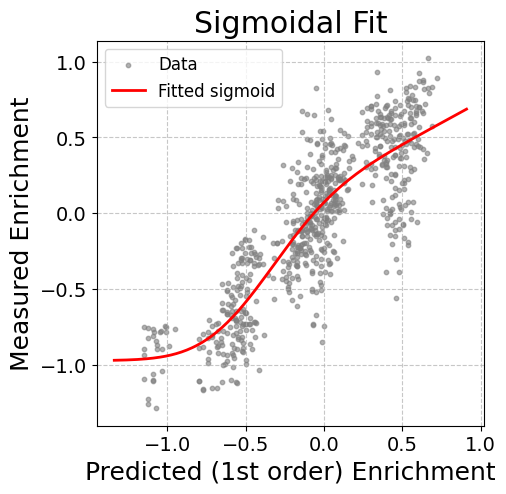

/tmp/ipython-input-3534172020.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ars_logo = logomaker.Logo(i1m.fillna(0).T,
/usr/local/lib/python3.12/dist-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '*' is not in color_dict. Using black.
  warnings.warn(str(Error))


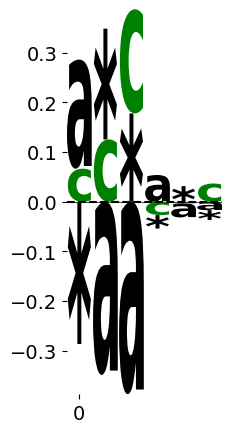

In [37]:
#@title Run a First-order Calculation and Detect Outliers
#@markdown The Outliers and Motif will be Calculated, along with a linearisation of the dataset. Data will be saved as motif.csv and outlier.csv in the specified path
for position in range(n):
    df_tang[str(position)] = df_tang[variant_column].str[position]



replicates = 1
pheno_pre_linear = phenotype_column
pheno = f'linearised_{pheno_pre_linear}'
weight = f'i{replicates}'

#pheno_pre_linear = 'ymean'

E0 = np.nanmean(df_tang[pheno_pre_linear])
E0_df = pd.DataFrame((['*'*n],[E0])).T
E0_df.columns = ['Epi', 'E_partial']
E1_df = epistasis_code(k=k, e = 1, n=n, df = df_tang, pheno = pheno_pre_linear,alphabet = AA_seq_)

En_df = pd.concat([E0_df,E1_df]) # 0th, 1st order terms

predicted_y_values = y_from_epi(En_df, df_tang, variant_name = variant_column)

# Assume error_function3, df_tang, pheno_pre_linear, predicted_y_values,
# and constraints are defined as in your original code

plt.figure(figsize=(5,5))

y_data = df_tang[pheno_pre_linear].values # Ensure it's a numpy array
x_data = np.array(predicted_y_values)
#sigma_n = df_tang['yerr'].values

# Perform the sigmoidal fit
try:
    params, covariance = curve_fit(error_function3, x_data, y_data,
                                   bounds=np.array(constraints).T
                                   , p0 = [0.12023848, -0.2531591,   0.40188085,  0.02006621, -0.35848657,  6.86860176]
                                   # sigma=1/sigma_n, # Uncomment if you want weighted fit
                                   # absolute_sigma=True # Uncomment if sigma are true std.dev.
                                  )
except RuntimeError:
    print("Curve fit failed. Check initial parameters, function, or data.")
    # Fallback or default params if fit fails, or handle error appropriately
    params = np.array([np.mean(constraint) for constraint in constraints]) # Example fallback

# Generate y-values from the fitted curve for the original x_data points
y_fit = error_function3(x_data, *params)

# --- Outlier Detection ---
residuals = y_data - y_fit

# --- Plotting ---
# Plot the data
plt.scatter(x_data, y_data, label='Data', s=10, alpha=0.6, c='grey') # Original data
#plt.errorbar(x_data, y_data, yerr=sigma_n, ls='', zorder=0, c='gray', alpha=0.5, label='_nolegend_')

# Plot the fitted curve (smoother line)
x_values_smooth = np.linspace(min(x_data) - (0.1 * (max(x_data)-min(x_data)) if len(x_data)>1 else 1),
                              max(x_data) + (0.1 * (max(x_data)-min(x_data)) if len(x_data)>1 else 1),
                              200)
y_values_smooth_fit = error_function3(x_values_smooth, *params)
plt.plot(x_values_smooth, y_values_smooth_fit, label='Fitted sigmoid', color='red', linewidth=2)


# Highlight outliers (using StDev method for this example, choose one or combine)

# Or highlight outliers using Z-score method:
# plt.scatter(outliers_z_score_x, outliers_z_score_y,
#             s=50, facecolors='none', edgecolors='green', linewidth=1.5,
#             label=f'Outliers (Z-score > {outlier_threshold_z})')


r_squared = stats.pearsonr(y_data, y_fit)[0] ** 2 # R^2 between observed y and fitted y
print(f'Pearson R-squared (Data vs Fit): {r_squared:.4f}')

plt.xlabel('Predicted (1st order) Enrichment')
plt.ylabel('Measured Enrichment')
plt.legend(fontsize = 12)
plt.title('Sigmoidal Fit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#!!!! add in a module in the future that just gives the motif as is
E1_df["Epi_char"] = E1_df["Epi"].str.extract(r'([^*])')
E1_df["Epi_pos0"] = E1_df["Epi"].str.replace(r'[^*].*', '', regex=True).str.len()
i1m = epi_to_matrix(E1_df)




ars_logo = logomaker.Logo(i1m.fillna(0).T,
                         color_scheme='chemistry',
                         #vpad=.1,
                         #width=0.1,
                          flip_below = False,
                          #baseline_width = 0.1,
                         #allow_nan=True,
                          figsize = (2,5)
                        )
axhline(0,0, ls = '--', c = 'black')
ars_logo.style_xticks(anchor=0, spacing=201, rotation=0)
ars_logo.style_spines(visible=False)


#outlier_df = df_tang[outliers_std_dev_mask]

#outlier_df.to_csv(f'{file_path}/outliers.csv')
i1m.reindex(AA_seq_).to_csv(f'{file_path}/motif.csv')


In [38]:
variant_column

'pep_encoded'

In [39]:
#@title Run a Second-order Calculation and Detect Pairwise Epistasis
#@markdown 2nd order epistasis calculations are performed after linearisation of the first order effects

for position in range(n):
    df_tang[str(position)] = df_tang[variant_column].str[position] # variant column used in place of 'pep_'

for replicates in range(replicates_count): # 3 is for 3 replicates
    seeds = np.random.randint(100, size=5)
    #print(seeds)
    np.save(f'seeds_{replicates}', seeds)
### linearisation coefficient


df_tang_backup = df_tang.copy()

####!!!! the following is horrible code! It shouldnt be translated
all_variants = pd.DataFrame(recrusive_kron_string(AA_involved, n))
all_variants.columns = [variant_column]
####!!!! the above is horrible code!

####!!!! grouping on m_index is also a horrible idea, as we should group on 'pep_' instead

merged_df = pd.merge(df_tang_backup, all_variants, on=variant_column, how='outer', indicator=True)
####!!!! grouping on m_index is also a horrible idea

different_variants = merged_df[merged_df['_merge'] != 'both']
missing_values_df__ = different_variants[variant_column]
missing_values_df__.columns = [variant_column]

### now, do a for loop and run all of the above
n = n
k = k
### STANDARD CODE modified Q value
r2_score_list_list_2_list = [] # r2 score collection
epsilon_list = []
epsilon_full_list = []
initial_guess = params

###  key part of data generation
for replicate in np.arange(replicates_count)+1: #range(1,4):
    #print(replicate)
    Epi_list_lists = []
    #r2_score_list_list = []
    test_data_reference_list = []
    #y_pred_reference_list = []

    # [ 0.15335244, -0.25501055,  0.26509992,  0.05803452, -0.2905526,  3.28917588]

    p0_list = [initial_guess,initial_guess,initial_guess]
    #!!!! this call of replicate is wrong!, we dont need weight as well
    pheno_pre_linear = f'y{replicate}' # phenotype of choice
    #weight = 'yerr'
    #!!!! we dont need the weight either
    pheno = f'linearised_{pheno_pre_linear}'

    for seed in seeds:
        seeds = np.load(f'seeds_{replicate-1}.npy')

        #df_tang = df_tang_backup_k20.copy()
        df_tang_copy = df_tang_backup.copy()
        preserve_count = int(len(df_tang) * 0.8)
        preserved_data = df_tang.sample(n=preserve_count, random_state = seed) # train test split
        print(seed)
        preserved_data['type'] = 'train'
        test_data = df_tang.drop(preserved_data.index) # seperate the data into two
        test_data['type'] = 'test'
        preserved_data_run = pd.concat([preserved_data, test_data[[variant_column,'type']], missing_values_df__])
        # add missing data
        preserved_data_run = preserved_data_run.sort_values(variant_column)


        ### generate 1st order
        E0 = np.nanmean(df_tang[phenotype_column])
        E0_df = pd.DataFrame((['*'*n],[E0])).T
        E0_df.columns = ['Epi', 'E_partial']
        E1_df = epistasis_code(k=k, e = 1, n=n, df = preserved_data, pheno = pheno_pre_linear, alphabet = AA_seq_)
        En_df = pd.concat([E0_df,E1_df]) # 0th, 1st order terms

        ### allocate the index notation based on 0,1,2
        #index_notation_name = recrusive_kron_string([str(i) for i in range(21)],3)
        preserved_data_run = preserved_data_run.sort_values(variant_column)
        #preserved_data_run['number_variant2'] = index_notation_name

        ### preserve only training data
        preserved_data_ = preserved_data_run[preserved_data_run['type'] == 'train'] # keep training data df

        preserved_data_pred = y_from_epi(En_df, preserved_data_[df_tang.columns]
                                        ,  variant_name = variant_column) # get phenotype prediction from En_df E1, E0

        x = np.array(preserved_data_pred) # must be an array
        y = preserved_data_[pheno_pre_linear]
        #sigma_n  = 1/preserved_data_[weight]
        x_data = x#[(y <= mesh[-1]) & (y >= mesh[0])]
        y_data = y#[(y <= mesh[-1]) & (y >= mesh[0])]

        params, covariance = curve_fit(error_function3, x_data, y_data
                               , p0 = p0_list[replicate - 1]
                                       #,sigma=sigma_n#, absolute_sigma=True
                               ,bounds = array(constraints).T
                              )


        x_values = np.linspace(min(x_data)-4, max(x_data)+4, 100)
        y_fit = error_function3(x_data, *params)
        yy = error_function3(x_values, *params)
        # Plot the data and the fitted curve
        #plt.scatter(x_data, y_data, label='Data', s = 1)
        r = stats.pearsonr(x_data, y_fit)[0] **2
        #print(f'Pearson r2: {r}')
        #plt.scatter(x_data, y_fit, label='Fitted sigmoid', color='red')
        # plt.scatter(x_values, yy, label='Fitted sigmoid', color='red')
        # plt.xlabel('x: Predicted Phenotype')
        # plt.ylabel('y: Actual Phenotype')
        # plt.legend()
        # plt.title('Err func Fit')
        # plt.show()

        # mask1 = (preserved_data_[pheno] >=  min_cut)
        # mask2 = (preserved_data_[pheno] <= error_function3(max(preserved_data_.predicted), *params))

        #clipped_arr_train = [inverse_error_function3(i, *params) for i in preserved_data_[pheno_pre_linear]]
        #print('line 82')
        #preserved_data_[f'linear_{pheno_pre_linear}'] = clipped_arr_train
        #print(params)
        np.save(f'params_{pheno_pre_linear}_r{replicate}_seed{seed}',params )
        # use clipped array for E2, E3 ... high order predictions

        ## annotate missing data and test data
        # testing data
        #test_data_annotated = pd.merge(test_data, preserved_data_run[['pdep_', 'number_variant2']], on = 'pep_')
        #clipped_arr_test = [inverse_error_function3(i, *params) for i in test_data_annotated[pheno_pre_linear]]
        #test_data_annotated[f'linear_{pheno_pre_linear}'] = clipped_arr_test

        # missing data
        #missing_values_df_annotated = missing_values_df[['pdep_','n1', 'n2', 'n3', 'y1', 'y2', 'y3']]
        #missing_values_df_annotated = pd.merge(missing_values_df_annotated, preserved_data_run[['pep_', 'number_variant2']], on = 'pep_')
        # clipped_arr_miss = [inverse_error_function3(i, *params) for i in missing_values_df_annotated[pheno_pre_linear]

        #plot(x_values, abs(np.gradient(yy)), marker = '.')
        #axhline(max(abs(np.gradient(yy))) * 0.01)
        #cutoff = max(abs(np.gradient(np.gradient(yy)))) * 0.05

        maximum_gradient = max(abs(np.gradient(yy)))
        maxima = x_values[np.gradient(yy) == maximum_gradient]
        minimum_gradient_left = min(abs(np.gradient(yy)[x_values < maxima]))
        minimum_gradient_right = min(abs(np.gradient(yy)[x_values > maxima]))

        cutoff_left = 0.0001 * (maximum_gradient - minimum_gradient_left) + minimum_gradient_left
        cutoff_right = 0.0001 * (maximum_gradient - minimum_gradient_right) + minimum_gradient_right

        min_cut = min(x_values[abs(np.gradient(yy))  > cutoff_left]) - 0.5
        max_cut = max(x_values[(abs(np.gradient(yy))  > cutoff_right) & (x_values  > maxima)]) + 1

        #print(min_cut,max_cut)
        min_cut = -3
        max_cut = 3
        # axvline(min_cut)
        # axvline(max_cut)

        # ylabel('Gradient of the error function fit')
        # xlabel('Linspaced x values (predictions)')
        # plt.show()

        # mask away the extremity datas
        df_tang_copy_run = df_tang_copy.copy()
        df_tang_copy_pred = y_from_epi(En_df, df_tang_copy_run,  variant_name = 'pep_')

        df_tang_copy_run['predicted'] = df_tang_copy_pred
        min_pheno_prelinear = error_function3(min_cut, *params) # this is the min pre_linearised phenotype allowed
        max_pheno_prelinear = error_function3(max_cut, *params) # this is the min pre_linearised phenotype allowed

        mask1 = (df_tang_copy_run[pheno_pre_linear]>=  min_pheno_prelinear)
        mask2 = (df_tang_copy_run['predicted']>=  min_cut)

        mask3 = (df_tang_copy_run[pheno_pre_linear]<=  max_pheno_prelinear)
        mask4 = (df_tang_copy_run['predicted']<= max_cut )

        df_tang_copy_run = df_tang_copy_run[mask2 & mask1 & mask3 & mask4]
        clipped_arr = [inverse_error_function3(i, *params) for i in df_tang_copy_run[pheno_pre_linear]]
        df_tang_copy_run[pheno] = clipped_arr
        # this df_tang_copy_run has clipped values based on the lineraisation for all values

        preserved_data_epistasis = pd.concat([df_tang_copy_run[[pheno, 'predicted']], preserved_data_run], axis = 1)
        # concat this clipped dataframe to the main run's dataframe
        # fill in np.NaN at positions where the data is labelled as 'test'
        test_data_annotated = preserved_data_epistasis[preserved_data_epistasis['type'] == 'test'].copy()
        preserved_data_epistasis.loc[preserved_data_epistasis['type'] == 'test', pheno] = np.nan
        preserved_data_epistasis = preserved_data_epistasis.sort_values(variant_column)

        E0 = nanmean(preserved_data_epistasis[pheno])
        E0_df = pd.DataFrame((['*'*n],[E0])).T
        E0_df.columns = ['Epi', 'E_partial']
        E1_df = epistasis_code(k=k, e = 1, n=n, df = preserved_data_epistasis[df_tang.columns.to_list() + [pheno]].dropna(), pheno = pheno,alphabet = AA_seq)
        E2_df = epistasis_code(k=k, e = 2, n=n, df = preserved_data_epistasis[df_tang.columns.to_list() + [pheno]].dropna(), pheno = pheno,alphabet = AA_seq)
        print('done E2')
        #E3_df = epistasis_code(k=k, e = 3, n=n, df = preserved_data_epistasis[df_tang.columns.to_list() + [pheno]].dropna(), pheno = pheno,alphabet = ['b']+AA_seq_[1:])
        #E4_df = epistasis_code(e = 4,k=k,n=n,df=preserved_data_epistasis, pheno = pheno)
        #E5_df = epistasis_code(e = 5,k=k,n=n,df=preserved_data_epistasis, pheno = pheno)
        #E6_df = epistasis_code(e = 6,k=k,n=n,df=preserved_data_epistasis, pheno = pheno)
        Epi_list = [E0_df,E1_df,E2_df]#,E3_df]
        Epi_list_lists.append(pd.concat(Epi_list).set_index('Epi'))
        test_data_reference_list.append(test_data_annotated)
        #print(test_data_annotated)

    epsilon_full_list.append(Epi_list_lists)

    ### turn the list of Df into a dataframe
    Epi_list_lists_2 = Epi_list_lists[0]#.set_index('Epi') # base case
    for i in Epi_list_lists[1:]:
        #i = i.set_index('Epi')
        Epi_list_lists_2 = pd.concat([i,Epi_list_lists_2], axis = 1)

    ### drop missing epistatic coefiicients
    #wt_RMS = Epi_list_lists_2#.dropna() # THIS CODE IS INEFFICIENT, IT DROPS EXCESSIVELY

    wt_RMS = Epi_list_lists_2.apply(calculate_pvalue_mean_and_error, axis=1).dropna()
    q_values = multipletests(wt_RMS.p_value, method='fdr_bh')[1]
    wt_RMS['q'] = q_values

    char_list = []
    for char in wt_RMS.index:
        char_list.append(n - char.count('*')) # get the epistatic order out
    wt_RMS['order'] = char_list

    wt_RMS_sig = wt_RMS[wt_RMS['q'] <= 0.05]
    #print(wt_RMS_sig.groupby('order').count())

    #wt_RMS_sig.columns = [0,1,2,3,4,'p','q','order'] # 0,1,2,3,4 refer to replicates
    wt_RMS_sig_ = wt_RMS_sig.copy()
    #wt_RMS['q_values'] = q_values
    #scatter(wt_RMS.nanmean, -log10(q_values), s = 5, c = wt_RMS['order'], cmap = 'jet')

    # minorticks_on()
    # xlabel('Linear/Epistasis Coefficients')
    # ylabel('- $log_{10}$ (q-value)')
    # axhline(-log10(0.05), ls = '--', c='k')
    # axvline(-0.2, ls = '--', c='k')
    # axvline(0.2, ls = '--', c='k')

    wt_RMS_sig['E_partial'] = wt_RMS_sig.nanmean
    wt_RMS_sig['E_err'] = wt_RMS_sig.nan_err

    wt_RMS_sig_ = pd.concat([wt_RMS_sig_, Epi_list_lists_2], axis = 1)
    wt_RMS_sig_.columns = list(wt_RMS_sig_.columns[:-5]) + [0, 1, 2, 3, 4]
    wt_RMS_sig_ = wt_RMS_sig_.dropna(subset = ['p_value']).fillna(0)
    plt.show()

    r2_score_list_list_2 = []
    y_pred_reference_list_2 = []
    for j in range(5): # 5 different cross validations used
        # future work should seperate train, test, validation?
        r2_score_list = []
        y_pred_list = []
        for i in range(1,int(max(wt_RMS_sig_.order)+1))[:]:
            test_data_reference = test_data_reference_list[j].dropna(subset = [pheno]) # dropna added to clip non-linear regime
            wt_RMS_sig_2 = wt_RMS_sig_[wt_RMS_sig_.order <= i] # choose less orders
            En_df = wt_RMS_sig_2[j].reset_index() # j is the index to choose the test set
            En_df.rename(columns={j : 'E_partial'}, inplace=True)
            y_pred = y_from_epi(En_df
           , df_tang[df_tang[variant_column].isin(test_data_reference.pep_.values.tolist())]
           ,  variant_name = variant_column)# predicted value
            #scatter(y_pred, test_data_reference[pheno], s = 5)
            #print(r2_score( test_data_reference[pheno], y_pred))
            #print(i)
            r2_score_list.append(r2_score( test_data_reference[pheno], y_pred))
            x_ = linspace(-5,5)
            y_pred_list.append(y_pred)
        #print()
        y_pred_reference_list_2.append(y_pred_list)
        r2_score_list_list_2.append(r2_score_list)

    r2_score_list_list_2_list.append(r2_score_list_list_2)
    epsilon_list.append(wt_RMS_sig)

    x = arange(len(r2_score_list_list_2[0])) + 1
    errorbar(x, pd.DataFrame(r2_score_list_list_2).T.mean(axis=1) * 100
            ,yerr = pd.DataFrame(r2_score_list_list_2).T.std(axis=1) * 100 / sqrt(5)
             , ls = '', marker = '', alpha = 1, ecolor = 'k')

    bar(x, pd.DataFrame(r2_score_list_list_2).T.mean(axis=1) * 100, zorder = 0)
    ylim(min(min(r2_score_list_list_2)) * 100 - 5 ,max(max(r2_score_list_list_2)) * 100 + 5)
    xlabel('Order of Epistasis/Linear\nTerms Used')
    ylabel('$r^{2}$ of Model')
    show()

np.save(f'{file_path}/r2_score_list_list_2_list.npy', np.array(r2_score_list_list_2_list))

import pickle
with open(f'{file_path}/epsilon_list', "wb") as fp:   #Pickling
       pickle.dump(epsilon_list, fp)

with open(f'{file_path}/epsilon_full_list', "wb") as fp:   #Pickling
       pickle.dump(epsilon_full_list, fp)

89


KeyError: 'y1'

In [ ]:
#@title Visualisaiton of Epistasis results
# @markdown This is what the calculated epistasis values looks like:

# @markdown Epi: epistasis/linear coefficient from the calculation

# @markdown order: the order of epistasis / linear term calculated

# @markdown E_partial: The epistasis coefficient's value scaled by its contribution to the final phenotype

# @markdown E_err: The associated error of the calculation

# @markdown q: The associated q-value of the calculation

wt_RMS_sig[['order','E_partial'	,'E_err','q',	]]

,order,E_partial,E_err,q
Epi,,,,
***,0,-0.488396,0.001551,0.000001
b**,1,-1.684553,0.034610,0.000062
P**,1,1.695694,0.011730,0.000006
G**,1,0.050076,0.010433,0.025409
A**,1,0.823464,0.008039,0.000011
...,...,...,...,...
*EW,2,-0.270607,0.029464,0.004203
*EH,2,0.238566,0.028448,0.005295
*ER,2,0.428299,0.010882,0.000089
